# Exploratory Model Analysis

*Purpose*: **TODO**.


## Core Idea: Curiosity and Skepticism

Remember the core principles of EDA:

1. Curiosity: Generate lots of ideas and hypotheses about your data.
2. Skepticism: Remain unconvinced of those ideas, unless you can find credible patterns to support them.

We can apply these same principles when studying a model; a process called *exploratory model analysis*. However, when studying a model, we have the means to more immediately test our hypotheses: We can *evaluate* the model to generate new data as we're carrying out our exploration!

These ideas can be a little abstract, so let's illustrate them with a concrete example.


## Setup


In [1]:
import grama as gr
import pandas as pd
DF = gr.Intention()
%matplotlib inline

## Running Example: Circuit model

The following code initializes a model for a [parallel RLC circuit](https://en.wikipedia.org/wiki/RLC_circuit#Parallel_circuit). I'm not expecting you to know any circuit theory; in fact, I chose this model because you're unlikely to know much about this system. We will use exploratory model analysis techniques to learn something about this model.


In [2]:
from grama.models import make_prlc_rand
md_circuit = make_prlc_rand()

# Basic Facts

Before we start exploring a model, we should first understand the basic facts about that model. This is most easily done in grama by printing the model's summary:


### __qX__ Model summary

Print the model summary for `md_circuit`. Answer the questions under *observations* below.


In [3]:
md_circuit 
# solution-end

/Users/zach/Git/py_grama/grama/marginals.py:336: RuntimeWarning: divide by zero encountered in double_scalars


model: RLC with component tolerances

  inputs:
    var_det:
      L: [1e-09, 0.001]
      R: [0.001, 1.0]
      C: [0.001, 100]

    var_rand:
      dR: (+0) uniform, {'mean': '0.000e+00', 's.d.': '3.000e-02', 'COV': inf, 'skew.': 0.0, 'kurt.': 1.8}
      dL: (+0) uniform, {'mean': '0.000e+00', 's.d.': '6.000e-02', 'COV': inf, 'skew.': 0.0, 'kurt.': 1.8}
      dC: (+0) uniform, {'mean': '3.000e-01', 's.d.': '2.900e-01', 'COV': 0.96, 'skew.': 0.0, 'kurt.': 1.8}

    copula:
      Independence copula

  functions:
      f0: ['R', 'dR', 'L', 'dL', 'C', 'dC'] -> ['Rr', 'Lr', 'Cr']
      f1: ['Lr', 'Cr'] -> ['omega0']
      parallel RLC: ['omega0', 'Rr', 'Cr'] -> ['Q']

*Observations*

- Compare the variability (measured by standard deviation) of the three random variables. Which is most variable?
  - `dC` has the largest variability, with `sd = 0.29`, as compared with `dR` (`sd = 0.03`) and `dL` (`sd = 0.06`).


## Model context

The symbols above don't tell us anything about what the model quantities *mean*. Here are some basic facts on the quantities in the model

| Variable | I/O | Description |
|---|---|---|
| `L` | Input | Nominal inductance |
| `R` | Input | Nominal resistance |
| `C` | Input | Nominal capacitance |
| `dL` | Input | Percent error on inductance |
| `dR` | Input | Percent error on resistance |
| `dC` | Input | Percent error on capacitance |
| `omega0` | Output | Natural frequency |
| `Q` | Output | Quality factor |

The deterministic variables `L, R, C` are the *designed* component values; these are selected by a circuit designer to achieve a desired performance. 

The random variables `dL, dR, dC` are *perturbations* to the designed component values. These random perturbations model the variability we would see in production, as manufactured components exhibit real variability.

The output `omega0` is the natural frequency; depending on the use-case, a designer would want to achieve a particular `omega0`. Thus having `omega0` lie close to some target value is desirable.

The output `Q` is the quality factor; a larger `Q` corresponds to a more "selective" circuit. Put differently, a higher `Q` helps the circuit reject unwanted signals.


# Inputs

First, let's get a sense for how the inputs of the model vary.


### __qX__ Overview of inputs

Generate a random sample from the model at its nominal deterministic values, and visualize all of the random **inputs**. Answer the questions under *observations* below.

*Hint*: You should be using `gr.ev_sample()` for this task. A particular keyword argument with `gr.ev_sample()` will allow you to generate the appropriate plot using `gr.pt_auto()`.


eval_sample() is rounding n...
Design runtime estimates unavailable; model has no timing data.
Calling plot_scattermat....


/Users/zach/Git/py_grama/grama/plot_auto.py:234: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


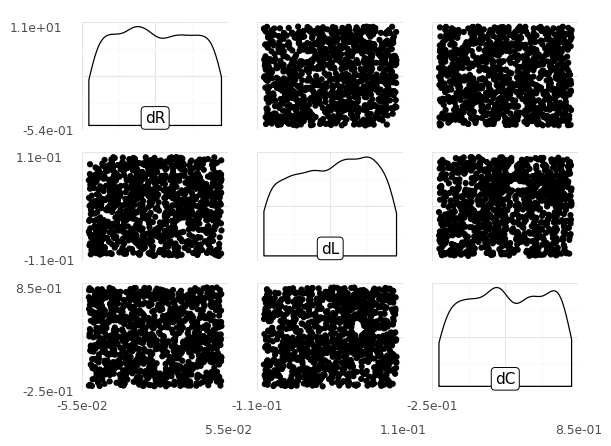

In [4]:
(
    md_circuit
    >> gr.ev_sample(n=1e3, df_det="nom", skip=True)
    >> gr.pt_auto()
)

*Observations*

*Note*: If you can't reliably make out the shapes of the distributions, try increasing `n`.

- What shape of distribution does each random input have?
  - All three distributions are uniform; we can see that from the marginals (along the diagonal), and from the model summary information above.
- What kind of dependency do the random inputs exhibit?
  - All three inputs are mutually independent; we can see that from the scatterplots (off-diagonal panels), and from the model summary information above (independence copula).


## Hypothesis: Same Variability

> Since the random perturbations `dL, dR, dC` are mutually independent, we should see the same variability regardless of the circuit component values.

You'll assess this hypothesis in the next task.


### __qX__ Compare designed and realized values

The following plot shows the designed and realized capacitance values. Answer the questions under *observations* below.

*Hint*: Remember that you can add `gr.scale_x_log10()` and `gr.scale_y_log10()` to a ggplot to change to a log-log scale.


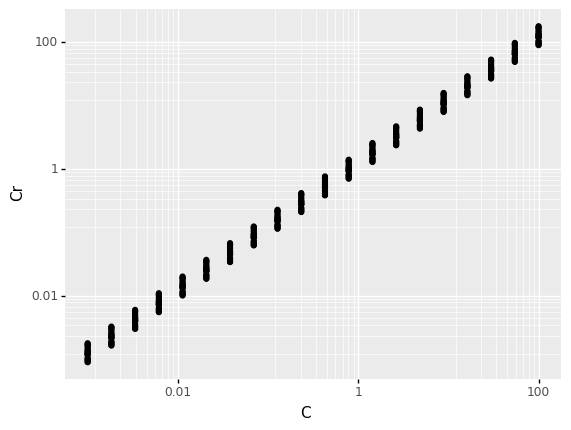

<ggplot: (8763311150466)>

In [5]:
# TASK: Inspect the following plot
(
    # NOTE: No need to edit this part of the code
    md_circuit
    >> gr.ev_sample(
        n=20,
        df_det=gr.df_make(
            R=1e-1,
            L=1e-5,
            C=gr.logspace(-3, 2, 20)
        )
    )
    # Visualize
    >> gr.ggplot(gr.aes("C", "Cr"))
    + gr.geom_point()
    + gr.scale_x_log10()
    + gr.scale_y_log10()
)

*Observations*

- Consider the hypothesis `we should see the same variability regardless of the circuit component values`. Is this hypothesis true?
  - This really depends on how we define "same variability"; since the variability is proportional to the component values (defined in terms of $\pm$ a fixed percentage), the variability  is greater for larger component values. However, the percentage variability is consistent regardless of the component value; this is easiest to see on a log-log scale.


# Outputs

Next, we'll study the outputs of the model "on their own"; that is, we're not yet going to look at the input-to-output relationships.


### __qX__ Nominal outputs

Evaluate the model at its nominal input values.


In [6]:
## TODO: Evaluate the model at its nominal input values
df_nominal = (
    md_circuit
    >> gr.ev_nominal(df_det="nom")
)

# NOTE: Use this to check your work
assert \
    isinstance(df_nominal, pd.DataFrame), \
    "df_nominal is not a DataFrame; did you evaluate the model?"

df_nominal

,dR,dL,dC,L,R,C,Q,Rr,omega0,Lr,Cr
0,0.0,0.0,0.3,0.0005,0.5005,50.0005,180.458653,0.5005,5.546971,0.0005,65.00065


### __qX__ Overview of outputs

Generate a random sample from the model at its nominal deterministic values, and visualize the distribution of **outputs**. Answer the questions under *observations* below.

*Hint*: This is a lot like __qX__ Overview of inputs. You should only need to use `gr.ev_sample()` and `gr.pt_auto()`.


eval_sample() is rounding n...
Calling plot_hists....


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


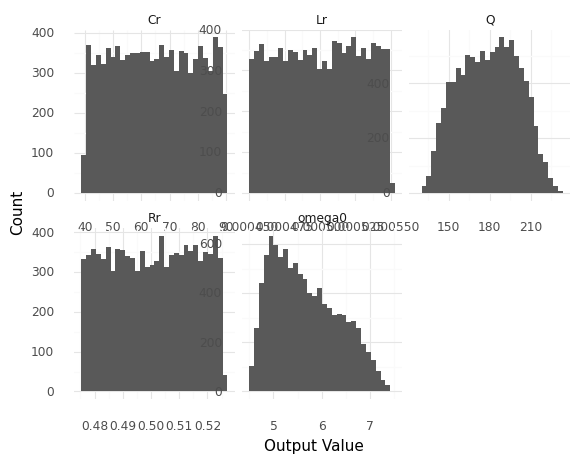

<ggplot: (8763303613248)>

In [7]:
(
    md_circuit

    >> gr.ev_sample(n=1e4, df_det="nom")
    >> gr.pt_auto()
)

*Observations*

*Note*: If you can't reliably make out the shapes of the distributions, try increasing `n`.

- What distribution shapes do the realized component values `Lr, Rr, Cr` have?
  - These are all uniform distributions
- What distribution shape does the output `Q` have?
  - This distribution is a bit bell-shaped, but it has a much flatter top and narrower tails than a gaussian.
- What distribution shape does the output `omega0` have?
  - This distribution is strongly asymmetric, with a longer right tail (right skew).


## Hypothesis: Nominal Outputs are Likely Outputs

Here's something we might intuitively expect:

> The nominal model outputs should be more likely output values.

You'll assess this hypothesis multiple different ways in the following tasks.


### __qX__ Compare distribution and nominal values for `omega0`

Create a plot that visualizes both a distribution of `omega0` and the nominal output value of `omega0`. Answer the questions under *observations* below.

*Hint*: One good way to do this is with a histogram and a vertical line.


eval_sample() is rounding n...


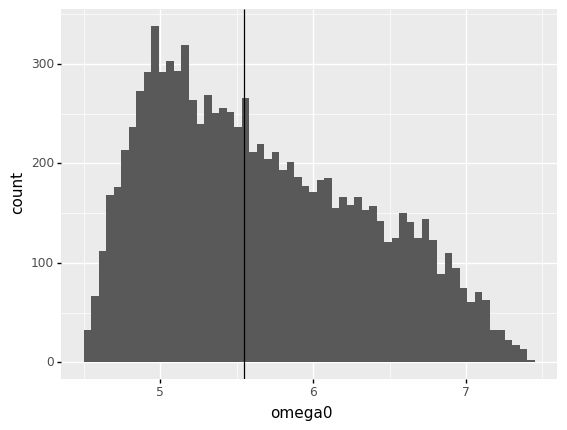

<ggplot: (8763311154990)>

In [8]:
(
    md_circuit
    >> gr.ev_sample(n=1e4, df_det="nom")
    >> gr.ggplot(gr.aes("omega0"))
    + gr.geom_histogram(bins=60)
    + gr.geom_vline(
        data=df_nominal,
        mapping=gr.aes(xintercept="omega0")
    )
)

*Observations*

- How does the hypothesis `The nominal model outputs should be more likely output values` hold up for `omega0`?
  - For `omega0` this hypothesis is somewhat false; the most likely value for `omega0` is around `5.0`, but the nominal value is closer to `5.5`. The nominal output value is certainly not the *most* unlikely value, though.


### __qX__ Density of outputs

Visualize a random sample of `Q` and `omega0` with a 2d bin plot. Increase the sample size `n` to get a "full" plot. Answer the questions under *observations* below.


eval_sample() is rounding n...


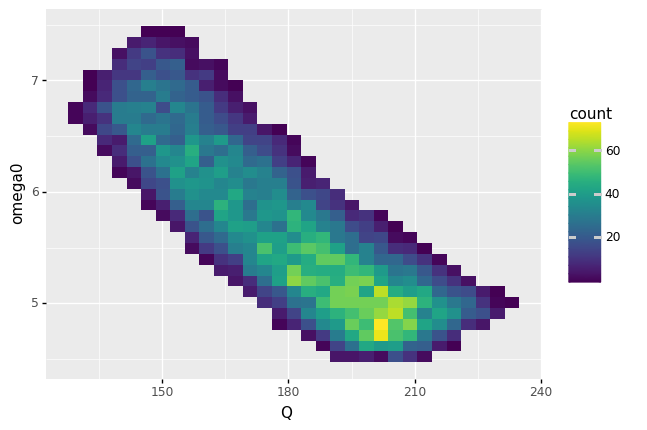

<ggplot: (8763303531936)>

In [9]:
(
    md_circuit

    >> gr.ev_sample(n=1e4, df_det="nom")
    >> gr.ggplot(gr.aes("Q", "omega0"))
    + gr.geom_bin2d()
)

*Observations*

- Briefly describe the distribution of realized performance (values of `Q` and `omega0`).
  - The distribution is oddly rectangular, with fairly "sharp" square sides. The distribution seems to end abruptly; there are exactly zero counts outside the "curved rectangle". The values of `Q` and `omega0` are negatively correlated; when `Q` is larger `omega0` tends to be smaller. The distribution is also asymmetric; note that highest `count` (brightest fill color) is *not* in the center, but rather towards the bottom-right.


### __qX__ Compare nominal with distribution

Add a point for the nominal output values to the following plot. Answer the questions under *observations* below.


eval_sample() is rounding n...


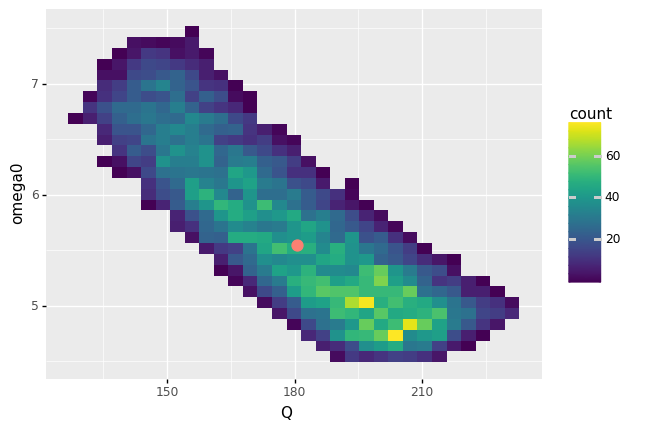

<ggplot: (8763311157447)>

In [10]:
## NOTE: You don't need to touch most of this code; 
## just the line indicated below
(
    md_circuit
    >> gr.ev_sample(n=1e4, df_det="nom")
    
    >> gr.ggplot(gr.aes("Q", "omega0"))
    + gr.geom_bin2d()
    + gr.geom_point(

        data=df_nominal,
        color="salmon",
        size=4,
    )
)

*Observations*

The nominal design (red point) represents the predicted performance if we assume the nominal circuit component values. 

- How does the distribution of real circuit performance (values of `Q`, `omega0`) compare with the nominal performance?
  - The distribution of real performance is quite large, and not at all symmetric about the nominal performance. The values `Q` and `omega0` exhibit negative correlation: when `Q` is larger `omega0` tends to be smaller.
- Is the most likely performance (values of `Q`, `omega0`) the same as the nominal performance? ("Most likely" is where `count` is the largest.)
  - No; the most likely performance is at a larger value of `Q` and smaller value of `omega0`.
- Assume that another system depends on the particular values of `Q` and `omega0` provided by this system. Would it be safe to assume the performance is within 1% of the nominal performance?
  - No; we see variability in `Q` and `omega0` far greater than 1%!


# Input-to-output Relationships

Now that we have a sense of both the inputs and outputs of the model, let's do some exploration to see how the two are related.


### __qX__ Correlation tile plot

Use the routine `tf_iocorr()` to transform the data from `ev_sample()` into input-to-output correlations. The `pt_auto()` routine will automatically plot those correlations as colors on a tile plot. Study the correlation tile plot, and answer the questions under *observations* below.

*Note*: You're going to see a *ton* of warnings when you run `tf_iocorr()` on the data; you'll think about what those mean in the questions below.


eval_sample() is rounding n...
Calling plot_corrtile....


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/Users/zach/opt/anac

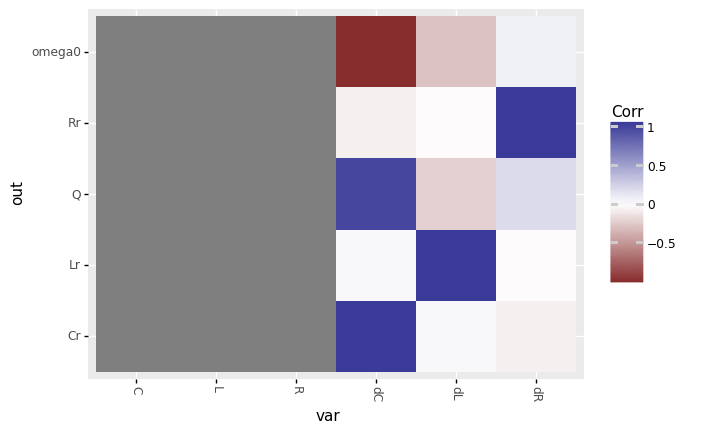

<ggplot: (8763303642555)>

In [11]:
(
    ## NOTE: No need to edit the call to ev_sample()
    md_circuit
    >> gr.ev_sample(
        n=1e3, 
        df_det="nom",
    )

    >> gr.tf_iocorr()
    ## NOTE: No need to edit; pt_auto will automatically
    ## adjust the plot to use the correlation data
    >> gr.pt_auto()
)

*Observations*

- The verb `tf_iocorr()` should throw a ton of warnings. What are these messages warning you about? Based on the colors in the plot, which correlations are not defined?
  - The warnings are for `input array is constant`; some of the values do not vary. Based on the plot, we can see that all correlations involving `L, R, C` are not defined.
- Do we have any information on how the outputs `omega0` and `Q` depend on the deterministic inputs `L, R, C`? How does this relate to the warnings we saw above?
  - No; the correlations between the outputs `omega0` and `Q` and inputs `L, R, C` are invalid. This is related to the warnings because `L, R, C` are each held at constant values. This is because we set `df_det="nom"` in the sample above; there is no variability in the inputs `L, R, C` by which to judge correlation with the outputs.
- Based on the available information: Which inputs does `omega0` depend on? How do those inputs affect `omega0`?
  - `omega0` depends on `dC` and `dL`; from this we can guess that is also depends on `C` and `L`. `omega0` is strongly negatively correlated with `dC`, and weakly negatively correlated with `dL`.
- Based on the available information: Which inputs does `Q` depend on? How do those inputs affect `Q`?
  - `Q` depends on all of `dC`, `dL`, and `dR`; from this we can guess that it also depends on `C, L, R`. `Q` is strongly positively correlated with `dC`, weakly positively correlated with `dR`, and weakly negatively correlated with `dL`.


## Hypothesis: `dR` has no effect on `omega0`

Based on the correlation tile plot above, we can formulate the following hypothesis:

> The variability in the resistance `dR` has no effect on the natural frequency `omega0`.

While this may seem obvious, it's important to keep in mind that correlation is a *crude* measure of dependency. For instance, the following code generates `X, Y` pairs that have a deterministic dependency, but very different correlation values:


   corr_linear     corr_quad
0          1.0  2.775558e-16


/Users/zach/Git/py_grama/grama/tran_pivot.py:471: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


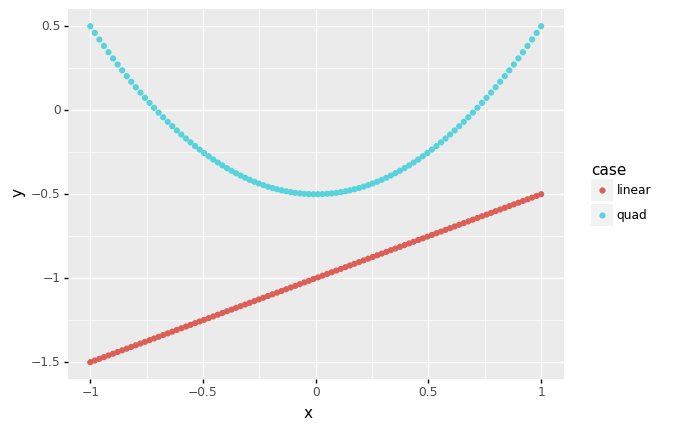

<ggplot: (8763311095077)>

In [12]:
## NOTE: No need to edit; run and inspect
# Generate data
df_example = (
    gr.df_make(x=gr.linspace(-1, +1, 100))
    >> gr.tf_mutate(
        y_linear=0.5 * DF.x - 1,
        y_quad=1.0 * DF.x**2 - 0.5,
    )
)

# Compute correlation coefficients
print(
    df_example
    >> gr.tf_summarize(
        corr_linear=gr.corr(DF.x, DF.y_linear),
        corr_quad=gr.corr(DF.x, DF.y_quad),
    )
)

# Visualize
(
    df_example
    >> gr.tf_pivot_longer(
        columns=["y_linear", "y_quad"],
        names_to=[".value", "case"],
        names_sep="_",
    )
    >> gr.ggplot(gr.aes("x", "y", color="case"))
    + gr.geom_point()
)

Note that the `y` most certainly depends on `x` in the `quad` case, but the correlation is zero; this is because correlation can only detect *linear* trends. Thus, we need to exercise caution when interpreting a correlation tile plot.

```{admonition} Correlation is a rough measure of dependency
Correlation is a rough measure of dependency; for instance, a zero correlation can hide nonlinear relationships.
```

We can further investigate the hypothesis formulated from the correlation tile plot by constructing some sweeps.


### __qX__ Sweeps

Construct a sinew plot to investigate how each input affects the outputs of the model. Answer the questions under *observations* below.

*Note*: You only need to sweep the random variables; you can use the nominal levels for the deterministic inputs.


Calling plot_sinew_outputs....


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


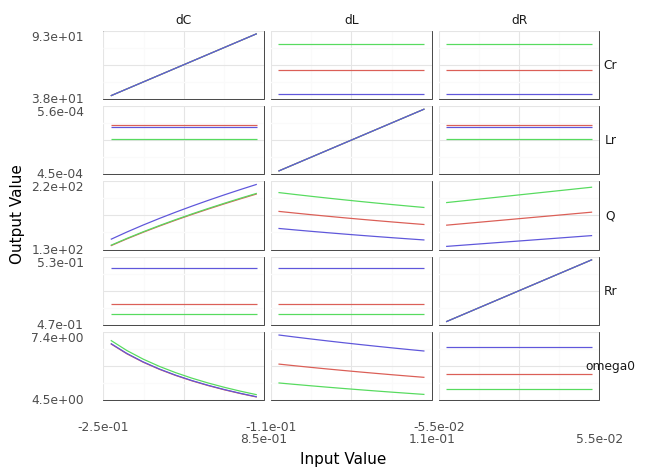

<ggplot: (8763303624807)>

In [13]:
(
    md_circuit

    >> gr.ev_sinews(df_det="nom")
    >> gr.pt_auto()
)

*Observations*

- How does the hypothesis *The variability in the resistance `dR` has no effect on the natural frequency `omega0`* hold up?
  - This hypothesis appears to be true! We see that the sweeps associated with `omega0` and `dR` are completely flat, indicating that there is no effect of `dR` on `omega0`.
